In [4]:
import numpy as np
import scipy as sp
from scipy import io
import cv2 as cv 
import matplotlib.pyplot as plt
import pylab
pylab.rcParams['figure.figsize'] = (12.0, 10.0)

# Part B: Condensation

The aim of this part is to track a given shape (template) as it moves in a sequence of
frames.
Such models may contain a variable that switches between cars and pedestrians, or traffic in different directions, or accelerating etc.
  


In [5]:
#Likelihood function is simple patch similarity

def computeLikelihood(image, template):
    #opencv's available methods
    methods = [cv.TM_CCOEFF, cv.TM_CCOEFF_NORMED, cv.TM_CCORR,
            cv.TM_CCORR_NORMED, cv.TM_SQDIFF, cv.TM_SQDIFF_NORMED]
    
    likelihood = cv.matchTemplate(image, template, methods[0])
    # Manually eliminate incorrect matches in the sky
    likelihood[:int(likelihood.shape[0] / 2), :] = 0.0
    
    # Pad to make this the size of the input image (for easier indexing)
    pad_first = int(template.shape[0])
    pad_second = int(template.shape[1])
    pad_amounts = ((pad_first, pad_first), (pad_second, pad_second))
    likelihood = np.pad(likelihood, pad_amounts, 'constant')
    
    return likelihood

We are matching this template with shape:  (27, 18, 3)


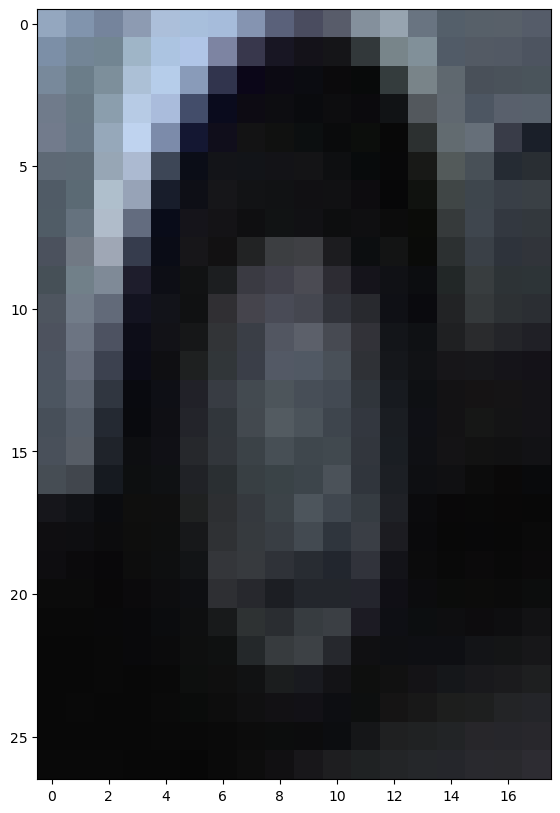

Processing Frame 0


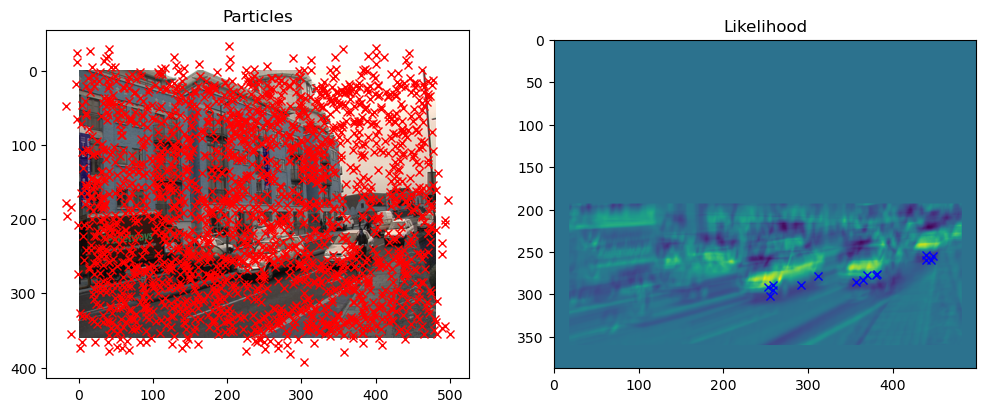

Processing Frame 1


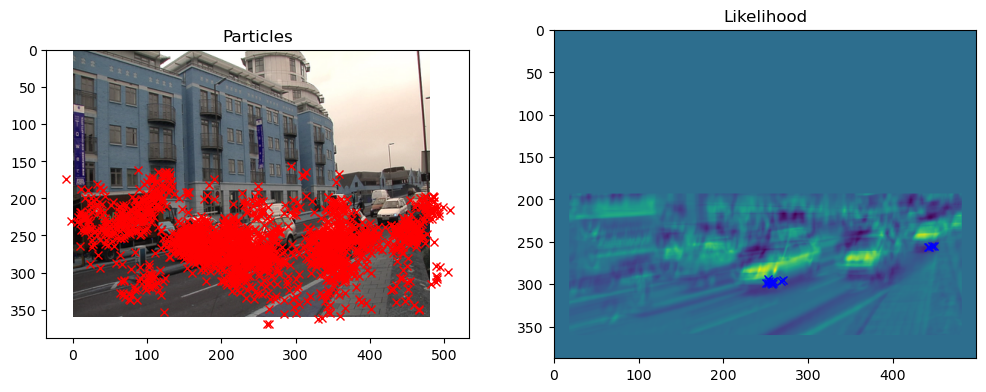

Processing Frame 2


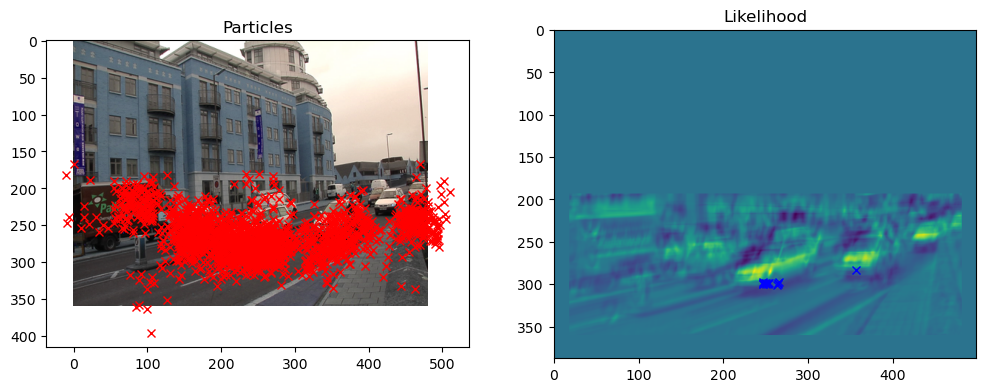

Processing Frame 3


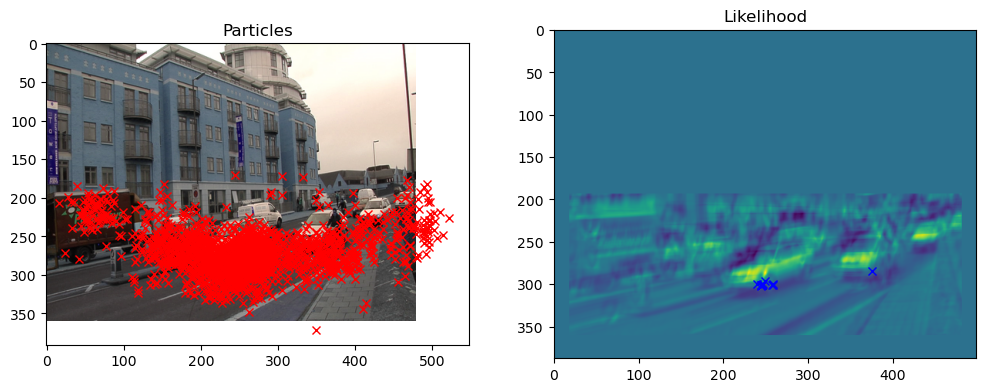

Processing Frame 4


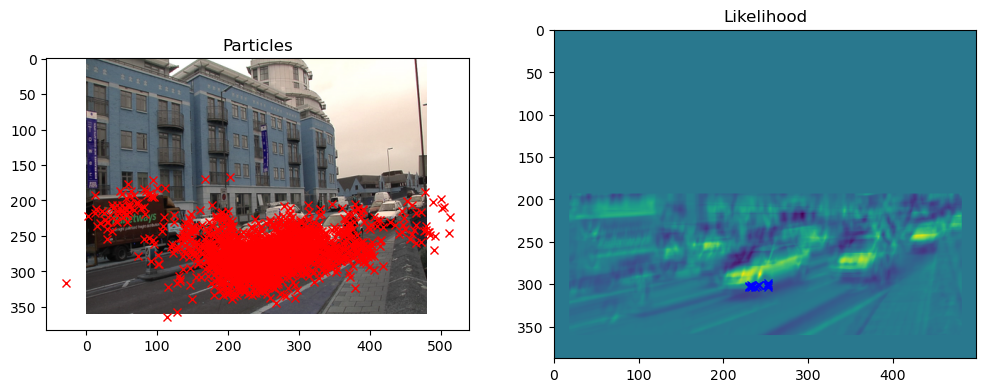

Processing Frame 5


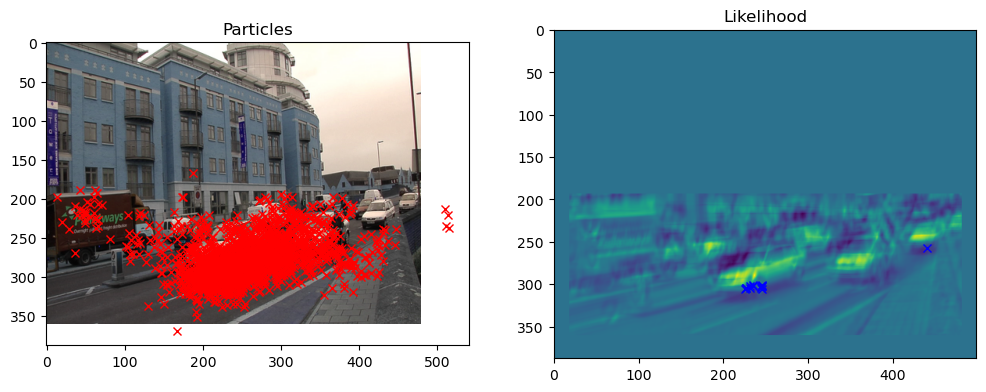

Processing Frame 6


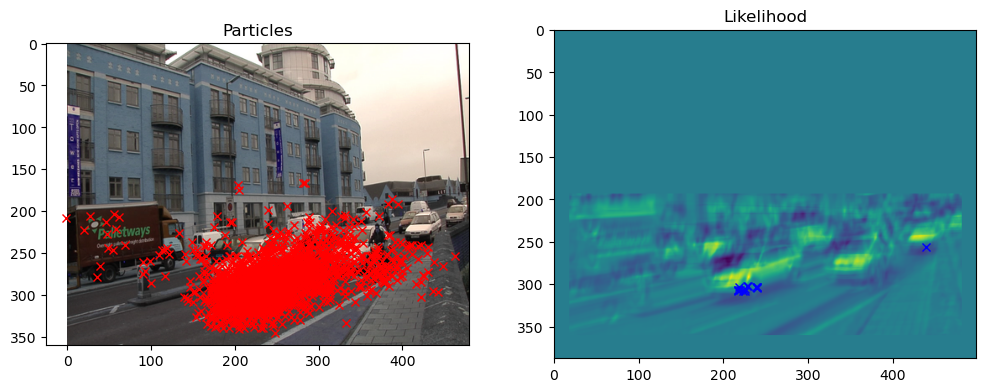

Processing Frame 7


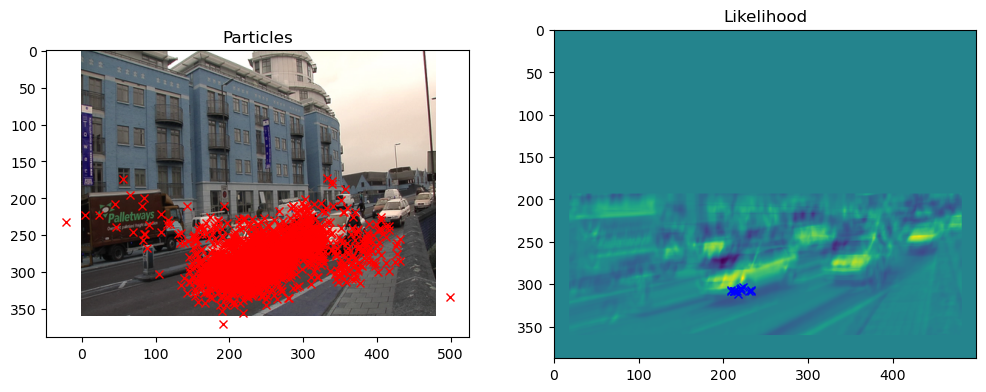

Processing Frame 8


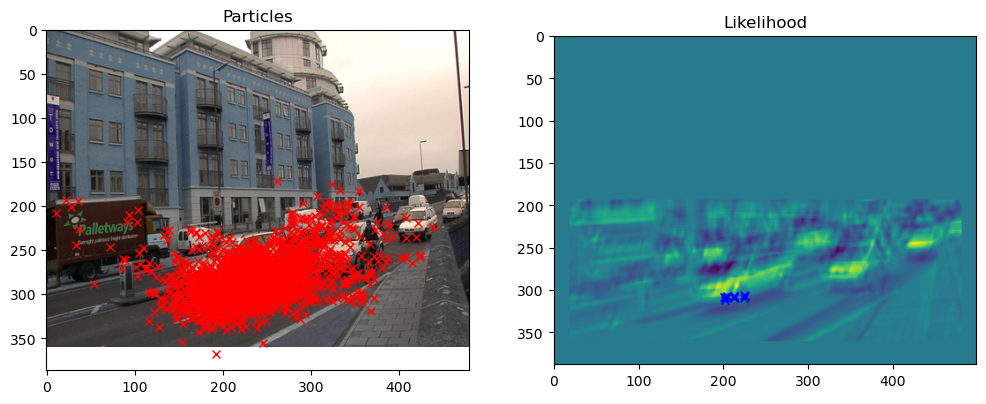

Processing Frame 9


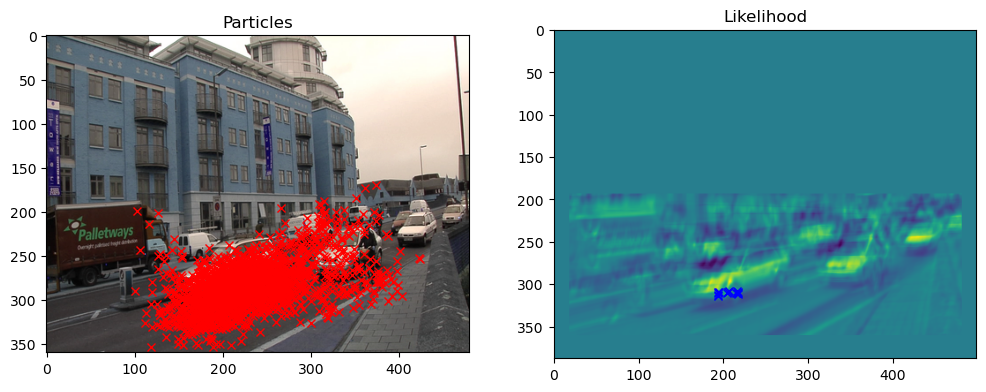

Processing Frame 10


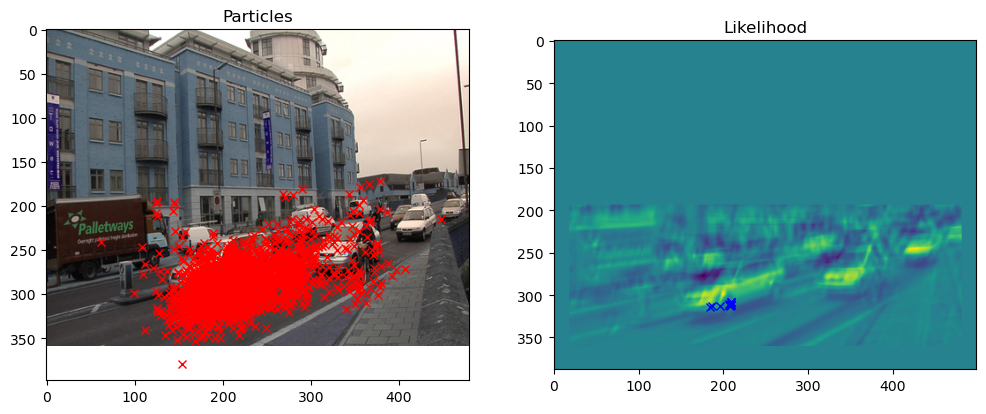

Processing Frame 11


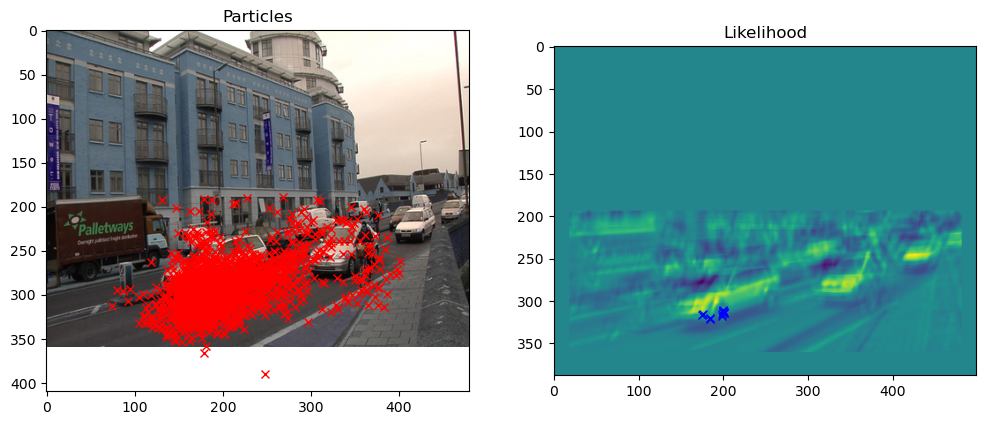

Processing Frame 12


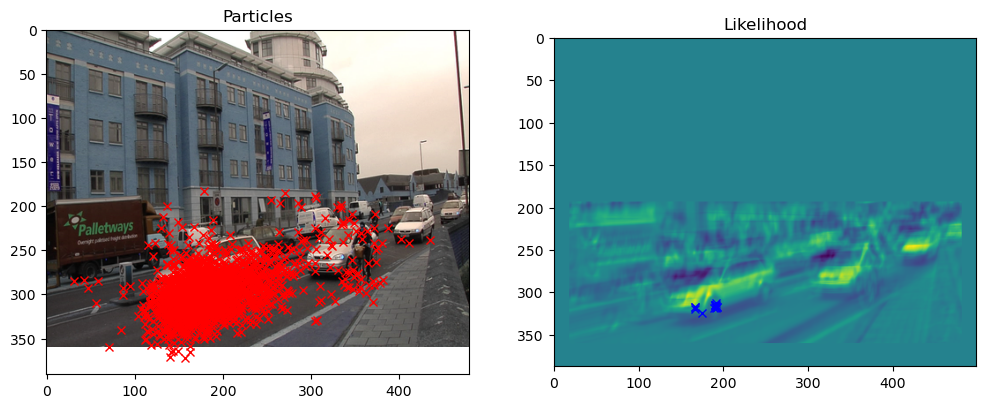

Processing Frame 13


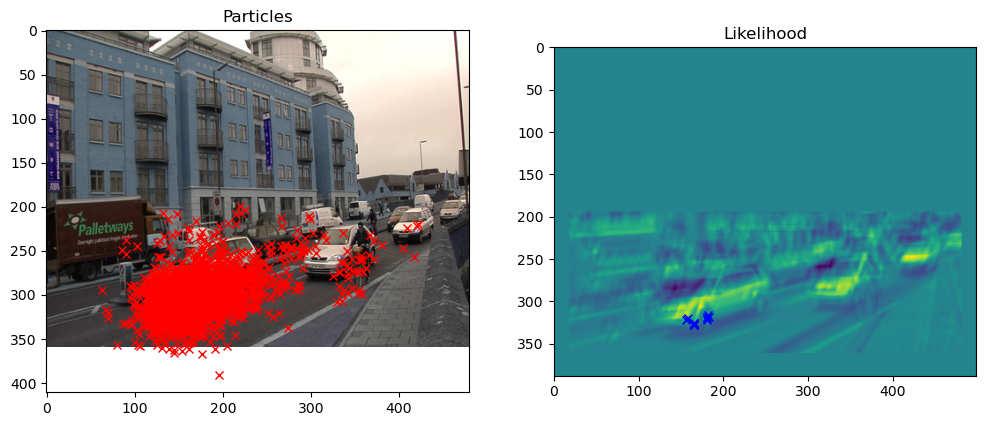

Processing Frame 14


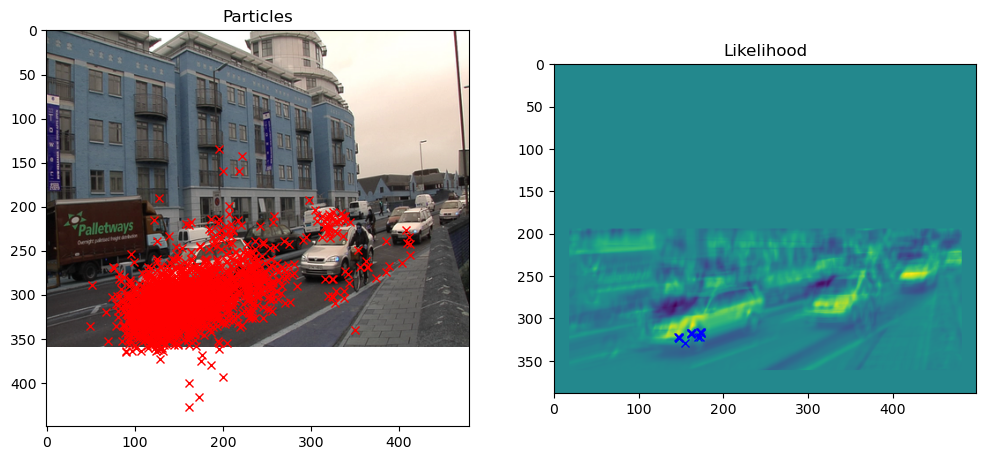

Processing Frame 15


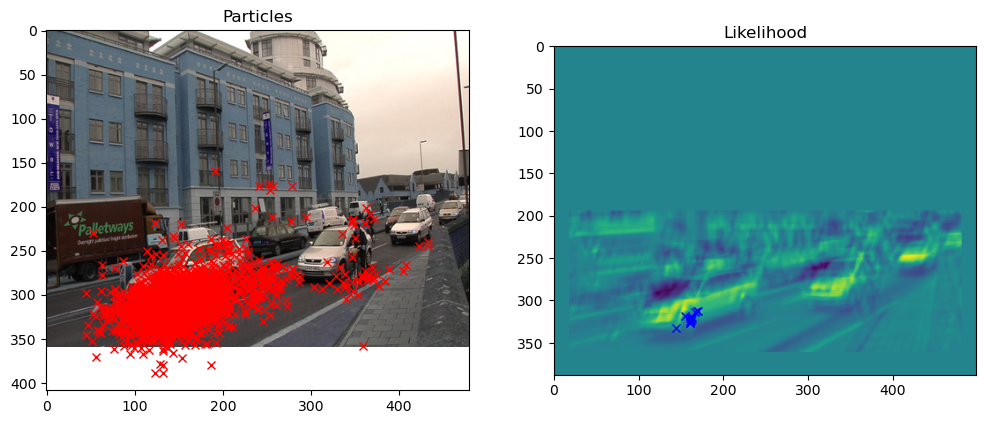

Processing Frame 16


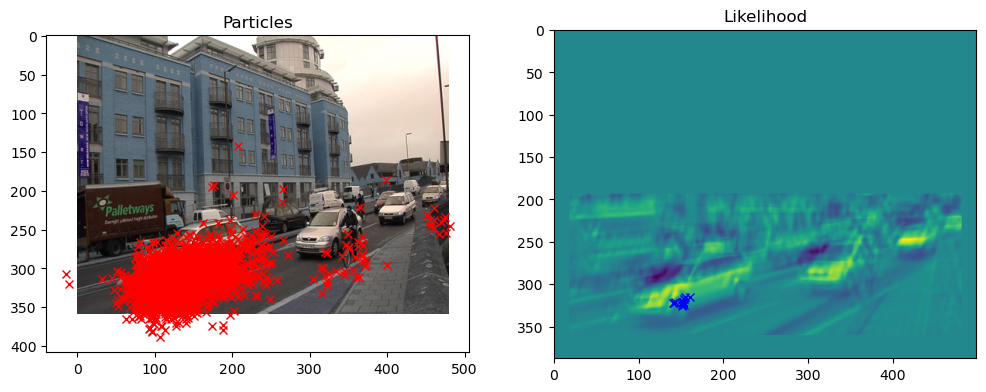

Processing Frame 17


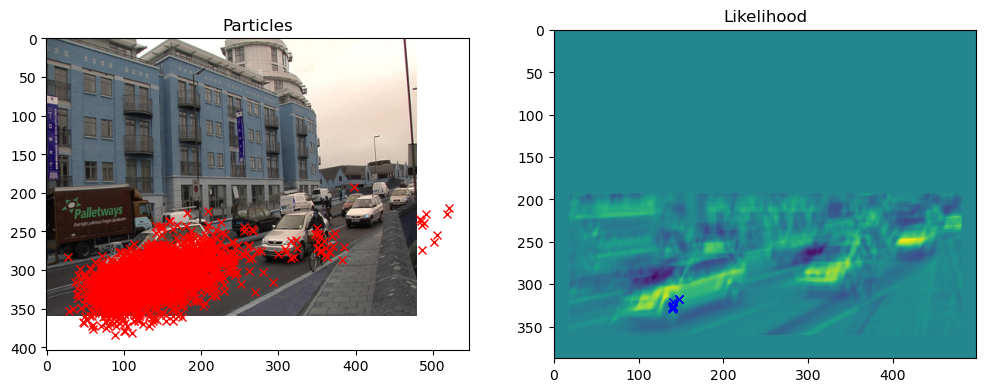

Processing Frame 18


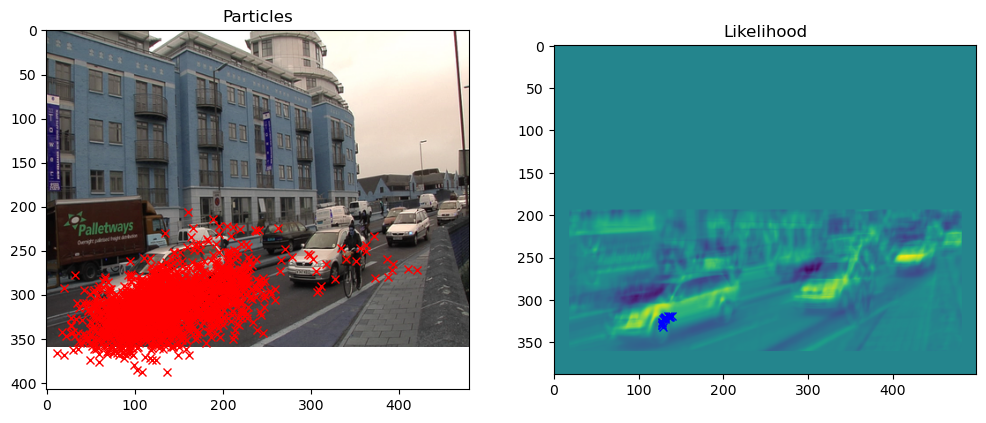

Processing Frame 19


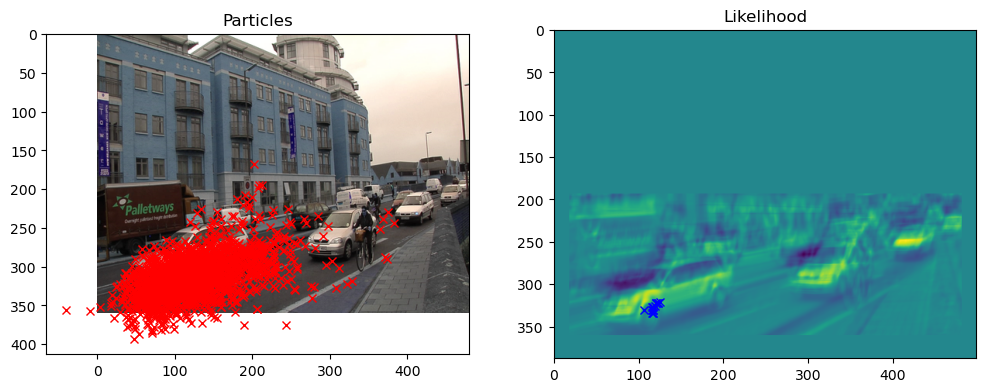

Processing Frame 20


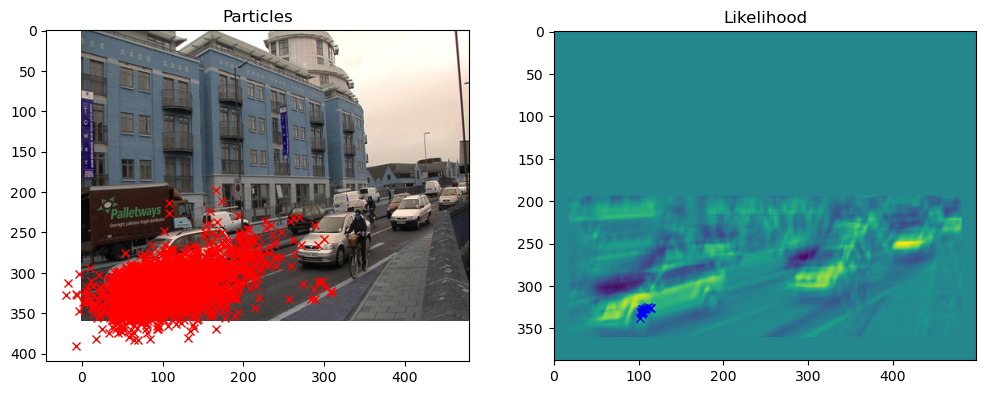

Processing Frame 21


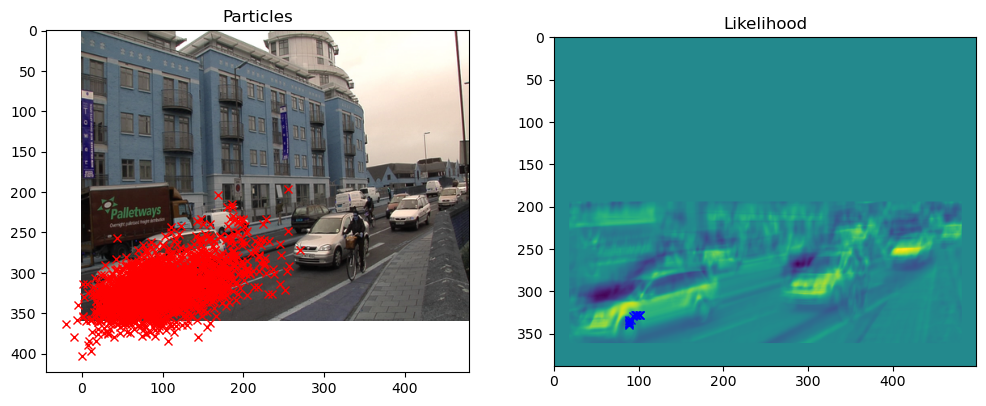

In [6]:
# Load template and starting position ('pos'), which come from frame 871.
template = sp.io.loadmat('data/Template.mat')['pixelsTemplate']

#let's show the template
print('We are matching this template with shape: ', template.shape)
plt.imshow(template)
plt.show()

# Load images
images = []
iFrame = 0
for frameNum in range(872, 894 + 1):
    imageName = 'data/HillsRdSkipFrames_%07d.png' % frameNum
    images.append(cv.imread(imageName))
    plt.show()
    iFrame += 1

imgHeight, imgWidth, colors = images[0].shape
numParticles = 2000;
weight_of_samples = np.ones((numParticles,1))

# Normalize the weights
weight_of_samples = weight_of_samples/weight_of_samples.sum()

# Initialize which samples from "last time" to propagate: all of them!:
samples_to_propagate = range(0, numParticles)

# ============================
# The first two dimensions represent position while the last two now represent velocity:
numDims_w = 4; 
# Randomly initialize some particles throughout the space of w:
particles_old = np.random.rand(numParticles, numDims_w)
particles_old[:,0] = particles_old[:,0] * imgHeight
particles_old[:,1] = particles_old[:,1] * imgWidth
particles_old[:,2] = 10.0 * np.random.randn(numParticles)
particles_old[:,3] = 10.0 * np.random.randn(numParticles)
# ============================

for iTime in range(22):
    print('Processing Frame', iTime)
    # Compute the cumulative sume of the weights.
    cum_hist_of_weights = np.cumsum(weight_of_samples)

    # ==============================================================
    # Resample the old distribution at time t-1, and select samples, favoring
    # those that had a higher posterior probability.
    # ==============================================================
    samples_to_propagate = np.zeros(numParticles, dtype=np.int32)
    
    # Pick random thresholds in the cumulative probability's range [0,1]:
    some_threshes = np.random.rand(numParticles)
    
    for sampNum in range(numParticles): 
        thresh = some_threshes[sampNum]
        for index in range (numParticles):
            if cum_hist_of_weights[index] > thresh:
                break
        samples_to_propagate[sampNum] = index

    # Predict where the particles from the old distribution of 
    # state-space will go in the next time-step. 
    particles_new = np.zeros(particles_old.shape)
    for particleNum in range(numParticles):      
        # Incorporate some noise, e.g. Gaussian noise with std 10,
        # into the current location (particles_old), to give a Brownian
        # motion model with changing velocity.
        
        noisePosition = np.random.normal(0,10, (2,))
        noiseVelocity = np.random.normal(0,10, (2,))
        
        particles_new[particleNum, 2:] = particles_old[samples_to_propagate[particleNum], 2:] + noiseVelocity
        
        particles_new[particleNum, :2] = particles_old[samples_to_propagate[particleNum], :2] + particles_old[samples_to_propagate[particleNum], 2:] + noisePosition
        particles_new[particleNum, :2] = np.round(particles_new[particleNum, :2]) # Round the particles_new to simplify Likelihood evaluation.
    
    #calculate likelihood function
    likelihood = computeLikelihood(images[iTime], template)
    
    #plot particles
    f, axarr = plt.subplots(1, 2)
    axarr[0].imshow(images[iTime])
    axarr[0].set_title('Particles')
    # now draw the particles onto the image
    axarr[0].plot(particles_new[:,1], particles_new[:,0], 'rx')
    
    
    #plot the likelihood
    axarr[1].imshow(likelihood)
    axarr[1].set_title('Likelihood')

    
    # Incorporate the data for the new state (time t):
    # The new particles accompanying predicted locations in state-space
    # for time t, are missing their weights: how well does each particle
    # explain the observations x_t
    for particleNum in range(numParticles):

        # Convert the particle from state-space w to measurement-space x:
        # Note: that step is trivial here since both are in 2D space of image
        # coordinates

        # Within the loop, evaluate the likelihood of each particle:
        particle = particles_new[particleNum, :]
        # Check that the predicted location is a place that
        # the likelihood can be really evaluated
        inFrame = particle[0] >= 0.0 and  particle[0] <= imgHeight and particle[1] >= 0.0 and particle[1] <= imgWidth
        if inFrame:
            minX = particle[1]
            minY = particle[0]

            weight_of_samples[particleNum] = likelihood[int(minY), int(minX)]
        else:
            weight_of_samples[particleNum] = 0.0

    # Normalize the weights
    weight_of_samples = weight_of_samples/weight_of_samples.sum()

    #Plot the 15 best scoring particles
    indices = np.argsort(weight_of_samples, axis = 0)
    bestScoringParticles = particles_new[np.squeeze(indices[-15:]), :]
    
    plt.plot(bestScoringParticles[:,1]+template.shape[1]/2, bestScoringParticles[:,0]+template.shape[0]/2, 'bx')
    plt.show()
    
    particles_old = particles_new


The first image is the template section in the frames to be tracked, whose likelihood is calculated in each frame to find the section that resembles it.

In Frame 0, the weights are initialized equally, leading to randomly distributed red crosses in the 'Particles' image. After the observation from the new state is incorporated, the 15 particles with the highest likelihood are marked blue, which are spread across the lower part of different cars. 

Along with the iteration, the red crosses are more and more concentrated on the car in the front, and the blue particles in the 'likelihood' move to the tire of the first car as expected. Although a small number of red crosses are located outside of the expected area due to noises added, they will not influence the likelihood due to their small weight.